In [1]:
import pydpmd as dp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

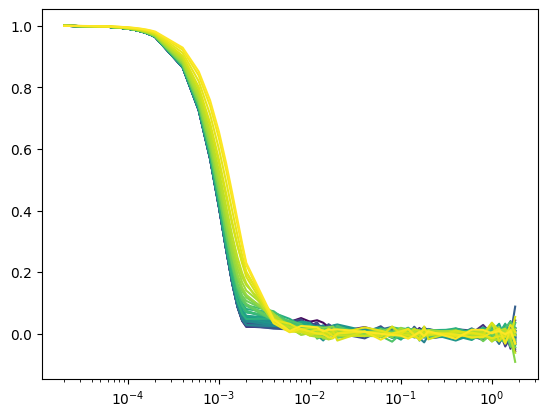

In [2]:
# root = '/home/mmccraw/dev/data/10-02-25/disk-shear-modulus-small/trial-0/'
root = '/home/mmccraw/dev/data/10-02-25/disk-shear-modulus-large/trial-0/'
dt = 2e-2
T = 1e-6
i = 0
phi_norm = plt.Normalize(vmin=0.8, vmax=0.85)
cmap = plt.cm.viridis
G0, tau, phi = [], [], []
while os.path.exists(shear_modulus_path := os.path.join(root, f'shear_modulus_{i}.npz')):
    i += 1
    shear_modulus = np.load(shear_modulus_path)
    G = np.mean(shear_modulus['shear_modulus'], axis=1)
    t = shear_modulus['t'] * dt * np.sqrt(T)
    phi.append(np.mean(shear_modulus['packing_fraction']))
    G0.append(G[0])
    tau.append(get_relaxation_time(G / G[0], t))
    plt.plot(t, G / G[0], c=cmap(phi_norm(phi[-1])))
plt.xscale('log')
# plt.yscale('log')
df = pd.DataFrame({'phi': phi, 'G0': G0, 'tau': tau})
df[df.phi < 0.84].to_csv('shear_modulus.csv', index=False)


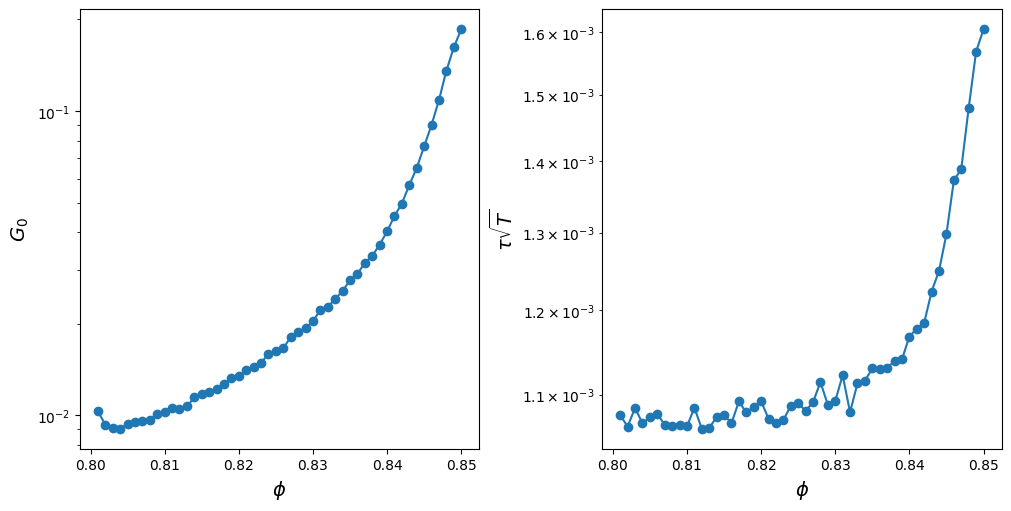

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
ax[0].plot(phi, G0, marker='o')
ax[1].plot(phi, tau, marker='o')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$G_0$', fontsize=14)
ax[1].set_ylabel(r'$\tau \sqrt{T}$', fontsize=14)
for a in ax:
    a.set_xlabel(r'$\phi$', fontsize=14)
plt.show()


In [112]:
import pydpmd as md
import numpy as np
import os
from system_building_resources import *
import time
import shutil
from correlation_functions import compute_shear_modulus
temp_path = tempfile.mkdtemp()
# build the initial data and equilibrate it, ideally to a 0-overlap state
radii = generate_bidisperse_radii(1000000, 0.5, 1.4)
which = 'small'
packing_fraction = 0.83
disk = build_disk_system_from_radii(radii, which, packing_fraction, int(np.random.randint(0, 1e9)))
disk.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(disk, 0.3)
disk.save(temp_path)
subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "disk_equilibrate_pbc"),
    temp_path,
    temp_path,
], check=True)

disk = load(temp_path, location=["final", "init"])
shutil.rmtree(temp_path)

Minimizing
Done


(0.0, 300.0)

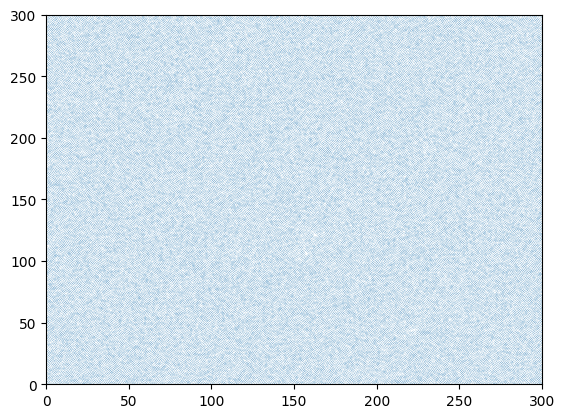

In [133]:
plt.scatter(*np.mod(disk.pos, disk.box_size).T, s=0.01)
# plt.scatter(*np.mod(disk.pos, disk.box_size).T, s=0.001)
s = 300
plt.xlim(0, s)
plt.ylim(0, s)

In [103]:
disk.rad *= 0.9

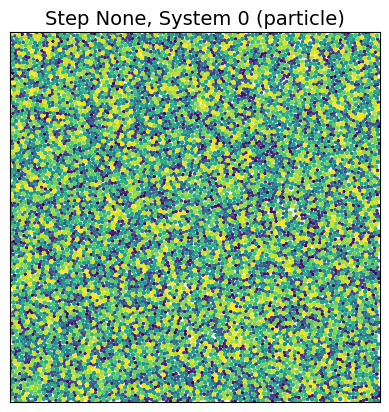

In [104]:
draw_particles_frame(None, plt.gca(), disk, 0, True, 'particle', 'viridis', None)